In [1]:
from torch.utils.data import DataLoader
import plotly.graph_objects as go
import datetime
import pickle

%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2


In [2]:
from IPython.display import SVG, display

def imshow(fig):
    return display(SVG(fig.to_image(format="svg")))

In [3]:
%cd /home/kevin/AutoInt
from src.integration.autoint import *
from src.experiment.autoint3d import *
from src.utils import get_device

device = get_device(free = False)

/home/kevin/AutoInt


# Learning 1D function


In [4]:
def func_to_fit(X):
    return np.sin(X)
dataset = Integral1DWrapper([0,6], func_to_fit, sampling_density=1024, device=device)
dataloader = DataLoader(dataset, shuffle=True, batch_size=64)

In [5]:
model = MLP1D(MultSequential).to(device)
train_1d(model, dataloader, device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0 	 Loss: 0.8637722339481115
Epoch 1 	 Loss: 0.07513066986575723
Epoch 2 	 Loss: 0.010826868616277352
Epoch 3 	 Loss: 0.002306972921360284
Epoch 4 	 Loss: 0.0006283091151999542
Epoch 5 	 Loss: 0.000181257295935211
Epoch 6 	 Loss: 7.467368004654418e-05
Epoch 7 	 Loss: 5.9455539485497866e-05
Epoch 8 	 Loss: 4.047811205509788e-05
Epoch 9 	 Loss: 3.452957776062249e-05
Epoch 10 	 Loss: 2.8877153226858354e-05
Epoch 11 	 Loss: 2.936935436537169e-05
Epoch 12 	 Loss: 2.5029032258316875e-05
Epoch 13 	 Loss: 2.8846238990354323e-05
Epoch 14 	 Loss: 3.0105694122539717e-05
Epoch 15 	 Loss: 0.002263915159574026
Epoch 16 	 Loss: 0.004317708193411818
Epoch 17 	 Loss: 0.0010152627664865577
Epoch 18 	 Loss: 0.00026010461283476616
Epoch 19 	 Loss: 6.566207639480126e-05
Epoch 20 	 Loss: 2.5786707055885927e-05
Epoch 21 	 Loss: 1.252773699889076e-05
Epoch 22 	 Loss: 9.097774409383419e-06
Epoch 23 	 Loss: 8.043457540907184e-06
Epoch 24 	 Loss: 8.134255494951503e-06
Epoch 25 	 Loss: 7.2550514147451395e-0

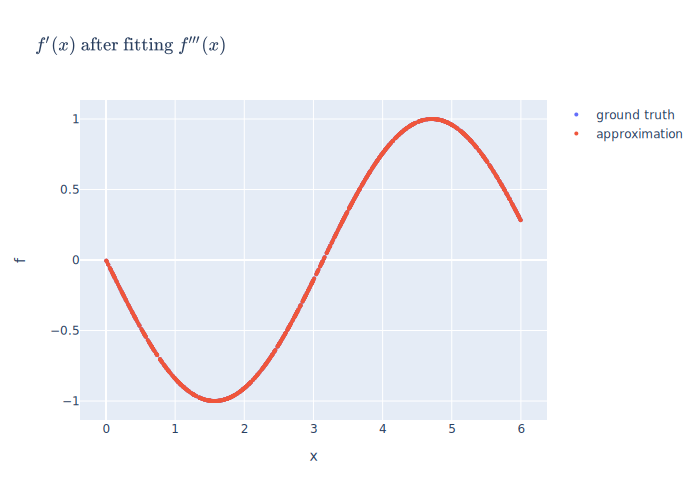

In [6]:
model.eval()

X = dataset.X.cpu().detach().numpy()
f_gt = -torch.sin(dataset.X).cpu().detach().numpy()
f_pd = model.dnforward(dataset.X, [0]).cpu().detach().numpy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=X, y=f_gt, mode='markers', name='ground truth',  marker_size=4))
fig.add_trace(go.Scatter(x=X, y=f_pd, mode='markers', name='approximation', marker_size=4))

fig.update_layout(
    title=r"$f'(x) \text{ after fitting } f'''(x)$",
    xaxis_title="x",
    yaxis_title="f",
)
imshow(fig)

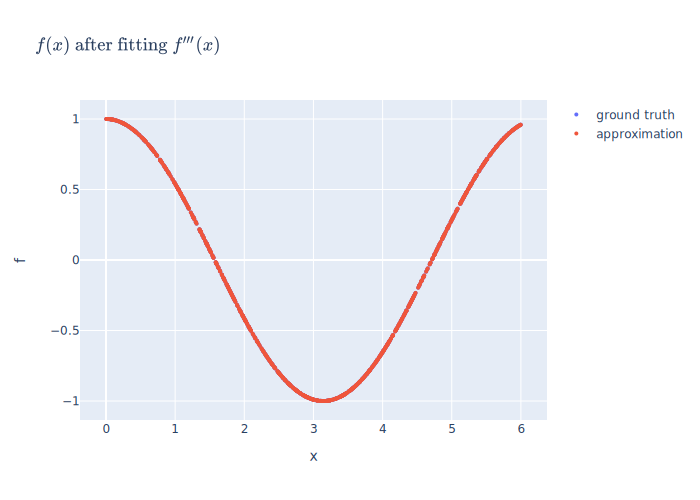

In [7]:
F_gt = torch.cos(dataset.X).cpu().detach().numpy()
F_pd = model(dataset.X).cpu().detach().numpy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=X, y=F_gt, mode='markers', name='ground truth', marker_size=4))
fig.add_trace(go.Scatter(x=X, y=F_pd, mode='markers', name='approximation', marker_size=4))

fig.update_layout(
    title=r"$f(x) \text{ after fitting } f'''(x)$",
    xaxis_title="x",
    yaxis_title="f",
)
imshow(fig)


## Comparing efficient implementation and default implementation

In [8]:
baseline = MLP1D(BaselineSequential).to(device)
baseline.layers.load_state_dict(model.layers.state_dict())
x = torch.rand(64, 1).to(device)

In [9]:
mix = MLP1D(MixSequential).to(device)
mix.layers.load_state_dict(model.layers.state_dict())
x = torch.rand(64, 1).to(device)

### Learning univariate partial derivative

In [10]:
from tqdm import trange

def benchmark(model, order):
    x_ = torch.rand_like(x)
    a = datetime.datetime.now()
    model.dnforward(x_, [0] * order)
    b = datetime.datetime.now()
    return b - a

x1time, x2time, x3time, x4time, btime, mtime = {}, {}, {}, {}, {}, {}

# Preheat
for _ in range(10):
    benchmark(mix, 8)

for order in range(1, 9): # 1st derivative to 8th derivative
    x1time[order] = []
    x2time[order] = []
    x3time[order] = []
    x4time[order] = []
    btime[order] = []
    mtime[order] = []
    for _ in trange(100): # 100 runs
        mix.layers.thres = 1
        x1time[order].append(benchmark(mix, order))
        mix.layers.thres = 2
        x2time[order].append(benchmark(mix, order))
        mix.layers.thres = 3
        x3time[order].append(benchmark(mix, order))
        mix.layers.thres = 4
        x4time[order].append(benchmark(mix, order))
        btime[order].append(benchmark(baseline, order))
        mtime[order].append(benchmark(model, order))


100%|██████████| 100/100 [03:40<00:00,  2.20s/it]


In [11]:
autoint_time = {'x1time': x1time, 'x2time': x2time, 'x3time': x3time, 'x4time': x4time,
                'btime': btime, 'mtime': mtime}
with open('data/external/autoint_time.pickle', 'wb') as handle:
    pickle.dump(autoint_time, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
with open('data/external/autoint_time.pickle', 'rb') as handle:
    autoint_time = pickle.load(handle)
locals().update(autoint_time)

In [13]:
orders = np.arange(1., 9.)
x1time_avg, x2time_avg, x3time_avg, x4time_avg, btime_avg, mtime_avg = [], [], [], [], [], []
for order in orders:
    x1time_avg.append(np.log(np.mean([t.total_seconds() for t in x1time[order]])))
    x2time_avg.append(np.log(np.mean([t.total_seconds() for t in x2time[order]])))
    x3time_avg.append(np.log(np.mean([t.total_seconds() for t in x3time[order]])))
    x4time_avg.append(np.log(np.mean([t.total_seconds() for t in x4time[order]])))
    btime_avg.append(np.log(np.mean([t.total_seconds() for t in btime[order]])))
    mtime_avg.append(np.log(np.mean([t.total_seconds() for t in mtime[order]])))

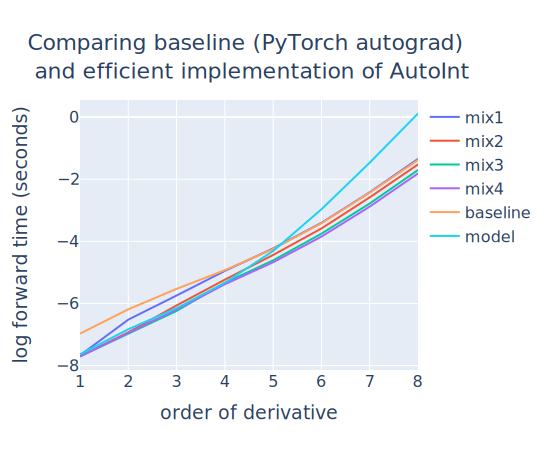

In [14]:
model.eval()

fig = go.Figure()
k = 10
fig.add_trace(go.Scatter(x=orders[:k], y=x1time_avg[:k], mode='lines', name='mix1',  marker_size=4))
fig.add_trace(go.Scatter(x=orders[:k], y=x2time_avg[:k], mode='lines', name='mix2',  marker_size=4))
fig.add_trace(go.Scatter(x=orders[:k], y=(x3time_avg[:k]), mode='lines', name='mix3',  marker_size=4))
fig.add_trace(go.Scatter(x=orders[:k], y=x4time_avg[:k], mode='lines', name='mix4',  marker_size=4))
fig.add_trace(go.Scatter(x=orders[:k], y=(btime_avg[:k]), mode='lines', name='baseline', marker_size=4))
fig.add_trace(go.Scatter(x=orders[:k], y=mtime_avg[:k], mode='lines', name='model', marker_size=4))

fig.update_layout(
    width=550,
    height=450,
    title=r"Comparing baseline (PyTorch autograd)<br> and efficient implementation of AutoInt",
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 1,
        dtick = 1
    ),
    xaxis_title="order of derivative",
    yaxis_title="log forward time (seconds)",
    font=dict(
        size=16
    )
)
imshow(fig)

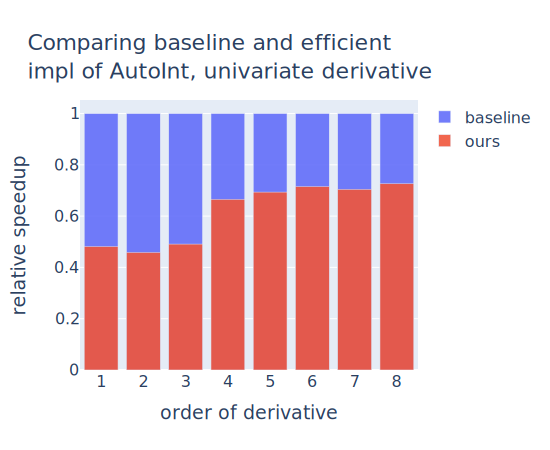

In [15]:
model.eval()

fig = go.Figure()
k = 10
fig.add_trace(go.Bar(x=orders[:k], y=np.ones_like(orders), name='baseline', opacity=0.9))
#fig.add_trace(go.Bar(x=orders[:k], y=np.exp(mtime_avg[:k])  / np.exp(btime_avg[:k]), name='model', opacity=0.9))
#fig.add_trace(go.Bar(x=orders[:k], y=np.exp(x1time_avg[:k]) / np.exp(btime_avg[:k]), name='mix1', opacity=0.9))
#fig.add_trace(go.Bar(x=orders[:k], y=np.exp(x2time_avg[:k]) / np.exp(btime_avg[:k]), name='mix2', opacity=0.9))
fig.add_trace(go.Bar(x=orders[:k], y=np.exp(x3time_avg[:k]) / np.exp(btime_avg[:k]), name='ours', opacity=0.9))
#fig.add_trace(go.Bar(x=orders[:k], y=np.exp(x4time_avg[:k]) / np.exp(btime_avg[:k]), name='mix4', opacity=0.9))

fig.update_layout(
    barmode='overlay',
    width=550,
    height=450,
    title=r"Comparing baseline and efficient <br> impl of AutoInt, univariate derivative",
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 1,
        dtick = 1
    ),
    xaxis_title="order of derivative",
    yaxis_title="relative speedup",
    font=dict(
        size=16
    )
)
imshow(fig)

In [16]:
m_optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
b_optimizer = torch.optim.Adam(baseline.parameters(), lr=5e-3)
x_optimizer = torch.optim.Adam(mix.parameters(), lr=5e-3)

#### Forward + Backward

In [17]:
def benchmark_backward(model, optimizer, order):
    """
    Benchmark time of forward + backward (regular training)
    """
    x_ = torch.rand_like(x)
    optimizer.zero_grad()
    a = datetime.datetime.now()
    loss = sum(model.dnforward(x_, [0] * order))
    loss.backward()
    optimizer.step()
    b = datetime.datetime.now()
    return b - a

In [18]:
x1time, x2time, x3time, x4time, btime, mtime = {}, {}, {}, {}, {}, {}

# Preheat
for _ in range(10):
    benchmark_backward(mix, x_optimizer, 8)

for order in range(1, 9): # 1st derivative to 8th derivative
    x1time[order] = []
    x2time[order] = []
    x3time[order] = []
    x4time[order] = []
    btime[order] = []
    mtime[order] = []

    for _ in trange(20): # 20 runs
        mix.layers.thres = 1
        x1time[order].append(benchmark_backward(mix, x_optimizer, order))
        mix.layers.thres = 2
        x2time[order].append(benchmark_backward(mix, x_optimizer, order))
        mix.layers.thres = 3
        x3time[order].append(benchmark_backward(mix, x_optimizer, order))
        mix.layers.thres = 4
        x4time[order].append(benchmark_backward(mix, x_optimizer, order))
        btime[order].append(benchmark_backward(baseline, b_optimizer, order))
        mtime[order].append(benchmark_backward(model, m_optimizer, order))

100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


In [19]:
backward_time = {'x1time': x1time, 'x2time': x2time, 'x3time': x3time, 'x4time': x4time,
                'btime': btime, 'mtime': mtime}
with open('data/external/backward_time.pickle', 'wb') as handle:
    pickle.dump(backward_time, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
with open('data/external/backward_time.pickle', 'rb') as handle:
    backward_time = pickle.load(handle)
locals().update(backward_time)

In [21]:
orders = np.arange(1., 9.)
x1time_avg, x2time_avg, x3time_avg, x4time_avg, btime_avg, mtime_avg = [], [], [], [], [], []
for order in orders:
    x1time_avg.append(np.log(np.mean([t.total_seconds() for t in x1time[order]])))
    x2time_avg.append(np.log(np.mean([t.total_seconds() for t in x2time[order]])))
    x3time_avg.append(np.log(np.mean([t.total_seconds() for t in x3time[order]])))
    x4time_avg.append(np.log(np.mean([t.total_seconds() for t in x4time[order]])))
    btime_avg.append(np.log(np.mean([t.total_seconds() for t in btime[order]])))
    mtime_avg.append(np.log(np.mean([t.total_seconds() for t in mtime[order]])))

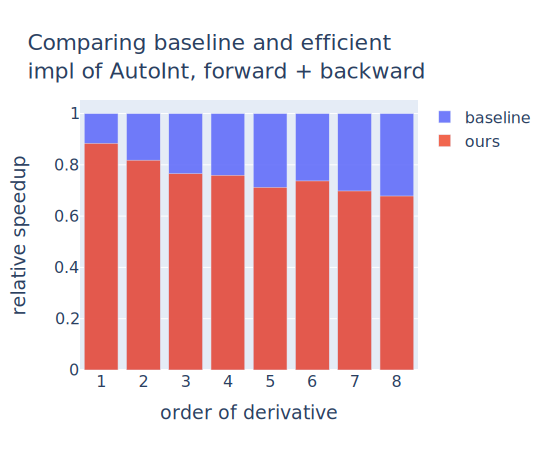

In [22]:
model.eval()

fig = go.Figure()
k = 10
fig.add_trace(go.Bar(x=orders[:k], y=np.ones_like(orders), name='baseline', opacity=0.9))
#fig.add_trace(go.Bar(x=orders[:k], y=np.exp(mtime_avg[:k])  / np.exp(btime_avg[:k]), name='model', opacity=0.9))
#fig.add_trace(go.Bar(x=orders[:k], y=np.exp(x1time_avg[:k]) / np.exp(btime_avg[:k]), name='mix1', opacity=0.9))
#fig.add_trace(go.Bar(x=orders[:k], y=np.exp(x2time_avg[:k]) / np.exp(btime_avg[:k]), name='mix2', opacity=0.9))
fig.add_trace(go.Bar(x=orders[:k], y=np.exp(x3time_avg[:k]) / np.exp(btime_avg[:k]), name='ours', opacity=0.9))
#fig.add_trace(go.Bar(x=orders[:k], y=np.exp(x4time_avg[:k]) / np.exp(btime_avg[:k]), name='mix4', opacity=0.9))

fig.update_layout(
    barmode='overlay',
    width=550,
    height=450,
    title=r"Comparing baseline and efficient <br> impl of AutoInt, forward + backward",
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 1,
        dtick = 1
    ),
    xaxis_title="order of derivative",
    yaxis_title="relative speedup",
    font=dict(
        size=16
    )
)
imshow(fig)

### Learning fully mixed partial derivative

In [23]:
model = MLPnD(MultSequential, 8).to(device)
x = torch.rand(64, 8).to(device)

In [24]:
baseline = MLPnD(BaselineSequential, 8).to(device)
baseline.layers.load_state_dict(model.layers.state_dict())

<All keys matched successfully>

In [25]:
mix = MLPnD(MixSequential, 8).to(device)
mix.layers.load_state_dict(model.layers.state_dict())

<All keys matched successfully>

In [26]:
from tqdm import trange

def benchmark(model, order):
    x_ = torch.rand_like(x)
    a = datetime.datetime.now()
    model.dnforward(x_, list(range(order)))
    b = datetime.datetime.now()
    return b - a

x1time, x2time, x3time, x4time, btime, mtime = {}, {}, {}, {}, {}, {}

# Preheat
for _ in range(10):
    benchmark(mix, 8)

for order in range(1, 9): # 1st derivative to 8th derivative
    x1time[order] = []
    x2time[order] = []
    x3time[order] = []
    x4time[order] = []
    btime[order] = []
    mtime[order] = []
    for _ in trange(20): # 20 runs
        mix.layers.thres = 1
        x1time[order].append(benchmark(mix, order))
        mix.layers.thres = 2
        x2time[order].append(benchmark(mix, order))
        mix.layers.thres = 3
        x3time[order].append(benchmark(mix, order))
        mix.layers.thres = 4
        x4time[order].append(benchmark(mix, order))
        btime[order].append(benchmark(baseline, order))
        mtime[order].append(benchmark(model, order))


100%|██████████| 20/20 [01:53<00:00,  5.66s/it]


In [27]:
autoint_time = {'x1time': x1time, 'x2time': x2time, 'x3time': x3time, 'x4time': x4time,
                'btime': btime, 'mtime': mtime}
with open('data/external/autoint_mixed_time.pickle', 'wb') as handle:
    pickle.dump(autoint_time, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [50]:
with open('data/external/autoint_mixed_time.pickle', 'rb') as handle:
    autoint_time = pickle.load(handle)
locals().update(autoint_time)

In [51]:
orders = np.arange(1., 9.)
x1time_avg, x2time_avg, x3time_avg, x4time_avg, btime_avg, mtime_avg = [], [], [], [], [], []
for order in orders:
    x1time_avg.append(np.log(np.mean([t.total_seconds() for t in x1time[order]])))
    x2time_avg.append(np.log(np.mean([t.total_seconds() for t in x2time[order]])))
    x3time_avg.append(np.log(np.mean([t.total_seconds() for t in x3time[order]])))
    x4time_avg.append(np.log(np.mean([t.total_seconds() for t in x4time[order]])))
    btime_avg.append(np.log(np.mean([t.total_seconds() for t in btime[order]])))
    mtime_avg.append(np.log(np.mean([t.total_seconds() for t in mtime[order]])))

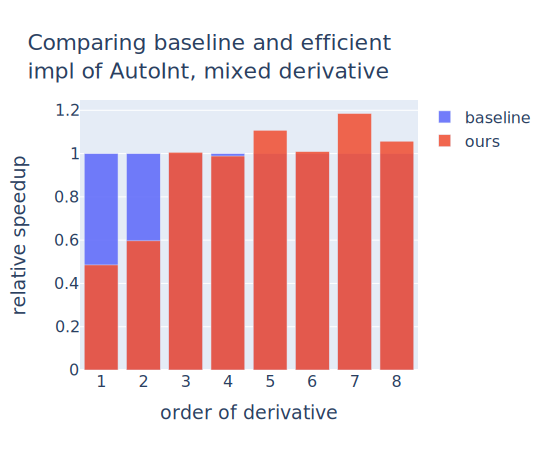

In [52]:
model.eval()

fig = go.Figure()
k = 10
#fig.add_trace(go.Bar(x=orders[:k], y=np.exp(mtime_avg[:k])  / np.exp(btime_avg[:k]), name='model', opacity=0.9))
fig.add_trace(go.Bar(x=orders[:k], y=np.ones_like(orders), name='baseline', opacity=0.9))
#fig.add_trace(go.Bar(x=orders[:k], y=np.exp(x1time_avg[:k]) / np.exp(btime_avg[:k]), name='mix1', opacity=0.9))
#fig.add_trace(go.Bar(x=orders[:k], y=np.exp(x2time_avg[:k]) / np.exp(btime_avg[:k]), name='mix2', opacity=0.9))
fig.add_trace(go.Bar(x=orders[:k], y=np.exp(x3time_avg[:k]) / np.exp(btime_avg[:k]), name='ours', opacity=0.9))
#fig.add_trace(go.Bar(x=orders[:k], y=np.exp(x4time_avg[:k]) / np.exp(btime_avg[:k]), name='mix4', opacity=0.9))

fig.update_layout(
    barmode='overlay',
    width=550,
    height=450,
    title=r"Comparing baseline and efficient <br> impl of AutoInt, mixed derivative",
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 1,
        dtick = 1
    ),
    xaxis_title="order of derivative",
    yaxis_title="relative speedup",
    font=dict(
        size=16
    )
)
imshow(fig)

#### Forward + Backward

In [31]:
def benchmark_backward(model, optimizer, order):
    """
    Benchmark time of forward + backward (regular training)
    """
    x_ = torch.rand_like(x)
    optimizer.zero_grad()
    a = datetime.datetime.now()
    loss = sum(model.dnforward(x_, list(range(order))))
    loss.backward()
    optimizer.step()
    b = datetime.datetime.now()
    return b - a

In [32]:
x1time, x2time, x3time, x4time, btime, mtime = {}, {}, {}, {}, {}, {}

# Preheat
for _ in range(10):
    benchmark_backward(mix, x_optimizer, 8)

for order in range(1, 9): # 1st derivative to 8th derivative
    x1time[order] = []
    x2time[order] = []
    x3time[order] = []
    x4time[order] = []
    btime[order] = []
    mtime[order] = []

    for _ in trange(20): # 20 runs
        mix.layers.thres = 1
        x1time[order].append(benchmark_backward(mix, x_optimizer, order))
        mix.layers.thres = 2
        x2time[order].append(benchmark_backward(mix, x_optimizer, order))
        mix.layers.thres = 3
        x3time[order].append(benchmark_backward(mix, x_optimizer, order))
        mix.layers.thres = 4
        x4time[order].append(benchmark_backward(mix, x_optimizer, order))
        btime[order].append(benchmark_backward(baseline, b_optimizer, order))
        mtime[order].append(benchmark_backward(model, m_optimizer, order))

100%|██████████| 20/20 [03:51<00:00, 11.55s/it]


In [33]:
backward_time = {'x1time': x1time, 'x2time': x2time, 'x3time': x3time, 'x4time': x4time,
                'btime': btime, 'mtime': mtime}
with open('data/external/mixed_backward_time.pickle', 'wb') as handle:
    pickle.dump(backward_time, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [34]:
with open('data/external/mixed_backward_time.pickle', 'rb') as handle:
    backward_time = pickle.load(handle)
locals().update(backward_time)

In [35]:
orders = np.arange(1., 9.)
x1time_avg, x2time_avg, x3time_avg, x4time_avg, btime_avg, mtime_avg = [], [], [], [], [], []
for order in orders:
    x1time_avg.append(np.log(np.mean([t.total_seconds() for t in x1time[order]])))
    x2time_avg.append(np.log(np.mean([t.total_seconds() for t in x2time[order]])))
    x3time_avg.append(np.log(np.mean([t.total_seconds() for t in x3time[order]])))
    x4time_avg.append(np.log(np.mean([t.total_seconds() for t in x4time[order]])))
    btime_avg.append(np.log(np.mean([t.total_seconds() for t in btime[order]])))
    mtime_avg.append(np.log(np.mean([t.total_seconds() for t in mtime[order]])))

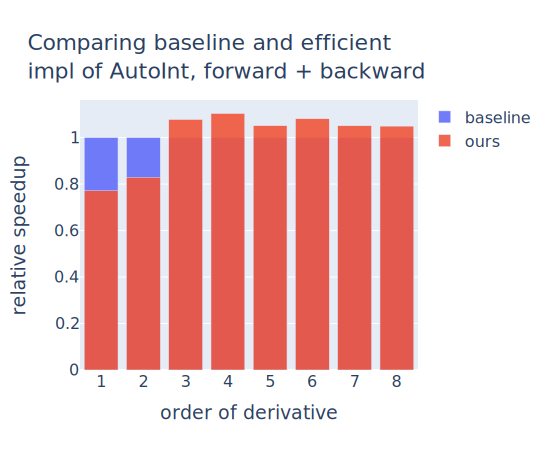

In [36]:
model.eval()

fig = go.Figure()
k = 10
fig.add_trace(go.Bar(x=orders[:k], y=np.ones_like(orders), name='baseline', opacity=0.9))
#fig.add_trace(go.Bar(x=orders[:k], y=np.exp(mtime_avg[:k])  / np.exp(btime_avg[:k]), name='model', opacity=0.9))
#fig.add_trace(go.Bar(x=orders[:k], y=np.exp(x1time_avg[:k]) / np.exp(btime_avg[:k]), name='mix1', opacity=0.9))
#fig.add_trace(go.Bar(x=orders[:k], y=np.exp(x2time_avg[:k]) / np.exp(btime_avg[:k]), name='mix2', opacity=0.9))
fig.add_trace(go.Bar(x=orders[:k], y=np.exp(x3time_avg[:k]) / np.exp(btime_avg[:k]), name='ours', opacity=0.9))
#fig.add_trace(go.Bar(x=orders[:k], y=np.exp(x4time_avg[:k]) / np.exp(btime_avg[:k]), name='mix4', opacity=0.9))

fig.update_layout(
    barmode='overlay',
    width=550,
    height=450,
    title=r"Comparing baseline and efficient <br> impl of AutoInt, forward + backward",
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 1,
        dtick = 1
    ),
    xaxis_title="order of derivative",
    yaxis_title="relative speedup",
    font=dict(
        size=16
    )
)
imshow(fig)

### Learning partially mixed partial derivative

In [37]:
model = MLPnD(MultSequential, 8).to(device)
x = torch.rand(64, 8).to(device)

In [38]:
baseline = MLPnD(BaselineSequential, 8).to(device)
baseline.layers.load_state_dict(model.layers.state_dict())

<All keys matched successfully>

In [39]:
mix = MLPnD(MixSequential, 8).to(device)
mix.layers.load_state_dict(model.layers.state_dict())

<All keys matched successfully>

In [40]:
from tqdm import trange

def benchmark(model, orders):
    x_ = torch.rand_like(x)
    a = datetime.datetime.now()
    model.dnforward(x_, orders)
    b = datetime.datetime.now()
    return b - a

x1time, x2time, x3time, x4time, btime, mtime = {}, {}, {}, {}, {}, {}

# Preheat
for _ in range(10):
    benchmark(mix, list(range(0, 8)))

for order in range(1, 9): # 1st derivative to 8th derivative
    x1time[order] = []
    x2time[order] = []
    x3time[order] = []
    x4time[order] = []
    btime[order] = []
    mtime[order] = []
    for _ in trange(100): # 100 runs
        orders = list(np.random.randint(0, order // 2 + 1, order))
        mix.layers.thres = 1
        x1time[order].append(benchmark(mix, orders))
        mix.layers.thres = 2
        x2time[order].append(benchmark(mix, orders))
        mix.layers.thres = 3
        x3time[order].append(benchmark(mix, orders))
        mix.layers.thres = 4
        x4time[order].append(benchmark(mix, orders))
        btime[order].append(benchmark(baseline, orders))
        mtime[order].append(benchmark(model, orders))


100%|██████████| 100/100 [06:13<00:00,  3.74s/it]


In [41]:
autoint_time = {'x1time': x1time, 'x2time': x2time, 'x3time': x3time, 'x4time': x4time,
                'btime': btime, 'mtime': mtime}
with open('data/external/autoint_partial_time.pickle', 'wb') as handle:
    pickle.dump(autoint_time, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [42]:
with open('data/external/autoint_partial_time.pickle', 'rb') as handle:
    autoint_time = pickle.load(handle)
locals().update(autoint_time)

In [43]:
orders = np.arange(1., 9.)
x1time_avg, x2time_avg, x3time_avg, x4time_avg, btime_avg, mtime_avg = [], [], [], [], [], []
for order in orders:
    x1time_avg.append(np.log(np.mean([t.total_seconds() for t in x1time[order]])))
    x2time_avg.append(np.log(np.mean([t.total_seconds() for t in x2time[order]])))
    x3time_avg.append(np.log(np.mean([t.total_seconds() for t in x3time[order]])))
    x4time_avg.append(np.log(np.mean([t.total_seconds() for t in x4time[order]])))
    btime_avg.append(np.log(np.mean([t.total_seconds() for t in btime[order]])))
    mtime_avg.append(np.log(np.mean([t.total_seconds() for t in mtime[order]])))

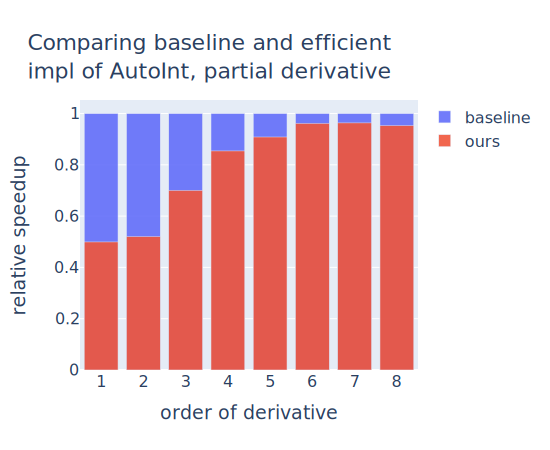

In [49]:
model.eval()

fig = go.Figure()
k = 10
#fig.add_trace(go.Bar(x=orders[:k], y=np.exp(mtime_avg[:k])  / np.exp(btime_avg[:k]), name='model', opacity=0.9))
fig.add_trace(go.Bar(x=orders[:k], y=np.ones_like(orders), name='baseline', opacity=0.9))
#fig.add_trace(go.Bar(x=orders[:k], y=np.exp(x1time_avg[:k]) / np.exp(btime_avg[:k]), name='mix1', opacity=0.9))
#fig.add_trace(go.Bar(x=orders[:k], y=np.exp(x2time_avg[:k]) / np.exp(btime_avg[:k]), name='mix2', opacity=0.9))
fig.add_trace(go.Bar(x=orders[:k], y=np.exp(x3time_avg[:k]) / np.exp(btime_avg[:k]), name='ours', opacity=0.9))
#fig.add_trace(go.Bar(x=orders[:k], y=np.exp(x4time_avg[:k]) / np.exp(btime_avg[:k]), name='mix4', opacity=0.9))

fig.update_layout(
    barmode='overlay',
    width=550,
    height=450,
    title=r"Comparing baseline and efficient <br> impl of AutoInt, partial derivative",
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 1,
        dtick = 1
    ),
    xaxis_title="order of derivative",
    yaxis_title="relative speedup",
    font=dict(
        size=16
    )
)
imshow(fig)

#### Forward + Backward

In [62]:
def benchmark_backward(model, optimizer, orders):
    """
    Benchmark time of forward + backward (regular training)
    """
    x_ = torch.rand_like(x)
    optimizer.zero_grad()
    a = datetime.datetime.now()
    loss = sum(model.dnforward(x_, orders))
    loss.backward()
    optimizer.step()
    b = datetime.datetime.now()
    return b - a

In [63]:
x1time, x2time, x3time, x4time, btime, mtime = {}, {}, {}, {}, {}, {}

# Preheat
for _ in range(10):
    benchmark_backward(mix, x_optimizer, list(range(0, 8)))

for order in range(1, 9): # 1st derivative to 8th derivative
    orders = list(np.random.randint(0, order // 2 + 1, order))
    x1time[order] = []
    x2time[order] = []
    x3time[order] = []
    x4time[order] = []
    btime[order] = []
    mtime[order] = []

    for _ in trange(20): # 20 runs
        mix.layers.thres = 1
        x1time[order].append(benchmark_backward(mix, x_optimizer, orders))
        mix.layers.thres = 2
        x2time[order].append(benchmark_backward(mix, x_optimizer, orders))
        mix.layers.thres = 3
        x3time[order].append(benchmark_backward(mix, x_optimizer, orders))
        mix.layers.thres = 4
        x4time[order].append(benchmark_backward(mix, x_optimizer, orders))
        btime[order].append(benchmark_backward(baseline, b_optimizer, orders))
        mtime[order].append(benchmark_backward(model, m_optimizer, orders))

100%|██████████| 20/20 [02:27<00:00,  7.37s/it]


In [64]:
backward_time = {'x1time': x1time, 'x2time': x2time, 'x3time': x3time, 'x4time': x4time,
                'btime': btime, 'mtime': mtime}
with open('data/external/partial_backward_time.pickle', 'wb') as handle:
    pickle.dump(backward_time, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [65]:
with open('data/external/partial_backward_time.pickle', 'rb') as handle:
    backward_time = pickle.load(handle)
locals().update(backward_time)

In [66]:
orders = np.arange(1., 9.)
x1time_avg, x2time_avg, x3time_avg, x4time_avg, btime_avg, mtime_avg = [], [], [], [], [], []
for order in orders:
    x1time_avg.append(np.log(np.mean([t.total_seconds() for t in x1time[order]])))
    x2time_avg.append(np.log(np.mean([t.total_seconds() for t in x2time[order]])))
    x3time_avg.append(np.log(np.mean([t.total_seconds() for t in x3time[order]])))
    x4time_avg.append(np.log(np.mean([t.total_seconds() for t in x4time[order]])))
    btime_avg.append(np.log(np.mean([t.total_seconds() for t in btime[order]])))
    mtime_avg.append(np.log(np.mean([t.total_seconds() for t in mtime[order]])))

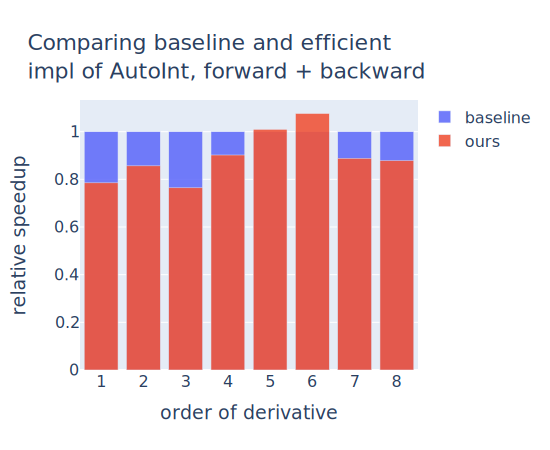

In [70]:
model.eval()

fig = go.Figure()
k = 10
fig.add_trace(go.Bar(x=orders[:k], y=np.ones_like(orders), name='baseline', opacity=0.9))
#fig.add_trace(go.Bar(x=orders[:k], y=np.exp(mtime_avg[:k])  / np.exp(btime_avg[:k]), name='model', opacity=0.9))
#fig.add_trace(go.Bar(x=orders[:k], y=np.exp(x1time_avg[:k]) / np.exp(btime_avg[:k]), name='mix1', opacity=0.9))
#fig.add_trace(go.Bar(x=orders[:k], y=np.exp(x2time_avg[:k]) / np.exp(btime_avg[:k]), name='mix2', opacity=0.9))
fig.add_trace(go.Bar(x=orders[:k], y=np.exp(x3time_avg[:k]) / np.exp(btime_avg[:k]), name='ours', opacity=0.9))
#fig.add_trace(go.Bar(x=orders[:k], y=np.exp(x4time_avg[:k]) / np.exp(btime_avg[:k]), name='mix4', opacity=0.9))

fig.update_layout(
    barmode='overlay',
    width=550,
    height=450,
    title=r"Comparing baseline and efficient <br> impl of AutoInt, forward + backward",
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 1,
        dtick = 1
    ),
    xaxis_title="order of derivative",
    yaxis_title="relative speedup",
    font=dict(
        size=16
    )
)
imshow(fig)